**Step 1:** We collect all the links for minutes from the Federal Reserve website.  Starting point is 1996.  Meeting minutes from prior to 2015 are in a different place to the more recent years. The FED seem to change the format of their minutes urls every few years, hence the extra if statement for 2007 through 2014. At the end of this block of code we've collected two lists. One is the links to minutes and the other is the meeting dates.

In [0]:
%%time
!pip install vaderSentiment
import matplotlib.pyplot as plt
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SIA
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import datetime
from functools import reduce

calendar_url = 'https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm'
recent_socket = urlopen(calendar_url)
recent_soup = BeautifulSoup(recent_socket, 'html.parser')

minutes = recent_soup.find_all('a', href=re.compile('^/monetarypolicy/fomcminutes\d{8}.htm'))
master_links = [minute.attrs['href'] for minute in minutes]

for year in range(2014, 1995, -1):
    year_url = "https://www.federalreserve.gov/monetarypolicy/fomchistorical%d.htm" % (year)
    year_socket = urlopen(year_url)
    year_soup = BeautifulSoup(year_socket, 'html.parser')
    if year > 2007:
        year_minutes = year_soup.find_all('a', href=re.compile('^/monetarypolicy/fomcminutes\d{8}.htm'))
    else:
        year_minutes = year_soup.find_all('a', href=re.compile('^/fomc/minutes/\d{8}.htm'))
    year_links = [year_minute.attrs['href'] for year_minute in year_minutes]
    master_links.extend(year_links)

temp_list = [re.match('(.*?).htm', x).group(1) for x in master_links]
date_list = [temp[-8:] for temp in temp_list]
print(master_links)
print(date_list)

['/monetarypolicy/fomcminutes20200129.htm', '/monetarypolicy/fomcminutes20190130.htm', '/monetarypolicy/fomcminutes20190320.htm', '/monetarypolicy/fomcminutes20190501.htm', '/monetarypolicy/fomcminutes20190619.htm', '/monetarypolicy/fomcminutes20190731.htm', '/monetarypolicy/fomcminutes20190918.htm', '/monetarypolicy/fomcminutes20191030.htm', '/monetarypolicy/fomcminutes20191211.htm', '/monetarypolicy/fomcminutes20180131.htm', '/monetarypolicy/fomcminutes20180321.htm', '/monetarypolicy/fomcminutes20180502.htm', '/monetarypolicy/fomcminutes20180613.htm', '/monetarypolicy/fomcminutes20180801.htm', '/monetarypolicy/fomcminutes20180926.htm', '/monetarypolicy/fomcminutes20181108.htm', '/monetarypolicy/fomcminutes20181219.htm', '/monetarypolicy/fomcminutes20170201.htm', '/monetarypolicy/fomcminutes20170315.htm', '/monetarypolicy/fomcminutes20170503.htm', '/monetarypolicy/fomcminutes20170614.htm', '/monetarypolicy/fomcminutes20170726.htm', '/monetarypolicy/fomcminutes20170920.htm', '/monetary

**Step 2:** Now we can loop through the list called `master_links` and scrape the minutes from each of these pages. We also create a more usable date format and some other derived columns.


In [0]:
%%time
df = pd.DataFrame(columns=['pydate', 'date', 'year', 'month', 'day', 'text', 'minute_length', 'retrieved_url'])

for i in range(len(master_links) - 1, 0, -1):
    url = 'https://www.federalreserve.gov' + master_links[i]
    res = requests.get(url)
    html_page = res.content
    soup = BeautifulSoup(html_page, 'html.parser')
    for script in soup(["script", "style"]):
        script.extract()
    text = soup.get_text()
    # break remove leading and trailing spaces in each line
    lines = (line.strip() for line in text.splitlines())
    blocks = (phrase.strip() for line in lines for phrase in line.split("  "))
    #removing blank lines and then placing all in one line
    text = '\n'.join(block for block in blocks if block)
    line = text.replace("\n", " ")
    df.loc[len(df)] = [datetime.datetime(int(date_list[i][:4]), int(date_list[i][4:6]), int(date_list[i][-2:])), date_list[i], int(date_list[i][:4]), int(date_list[i][5:6]), int(date_list[i][7:8]), line, len(line), url]

print(df.head())
df.to_json('fomc.json', orient='columns') #saving for storage or future use


      pydate  ...                                      retrieved_url
0 1996-12-17  ...  https://www.federalreserve.gov/fomc/minutes/19...
1 1996-11-13  ...  https://www.federalreserve.gov/fomc/minutes/19...
2 1996-09-24  ...  https://www.federalreserve.gov/fomc/minutes/19...
3 1996-08-20  ...  https://www.federalreserve.gov/fomc/minutes/19...
4 1996-07-02  ...  https://www.federalreserve.gov/fomc/minutes/19...

[5 rows x 8 columns]
CPU times: user 20.5 s, sys: 297 ms, total: 20.8 s
Wall time: 1min 11s


**Step 3:** In this step, we use VADER Sentiment Analysis library to get scores (positive, negative and neutral) based on the text of each meetings minutes. Sentiment Analysis of the minutes using the VADER SENTIMENT Analysis library

In [0]:
%%time
sid = SIA()
dfScores = pd.DataFrame()

for index, row in df.iterrows():
    scores = sid.polarity_scores(row['text'])
    dfTemp = pd.DataFrame.from_dict([scores])
    dfScores = dfScores.append(dfTemp)



CPU times: user 8min 16s, sys: 105 ms, total: 8min 16s
Wall time: 8min 19s


**Step 4:** We present summary statistics, in the form of the average sentiment per year as presented in Table 0.  Then we plot the negative and positve sentiment over time as shown in chart 0.

Table 0 - The Positive, Negative and Neutral Sentiment in FOMC Minutes (1990-2019)


,pos,neg,neu
year,,,
1996,0.109125,0.044875,0.846000
1997,0.116500,0.040375,0.843125
1998,0.113875,0.050250,0.835625
1999,0.116000,0.044125,0.839875
2000,0.119000,0.045333,0.835667
2001,0.109000,0.068333,0.822667
2002,0.117750,0.057250,0.825000
2003,0.112250,0.060250,0.827500
2004,0.118125,0.038500,0.843250


 
Chart 0 - The Positive, Negative and Neutral Sentiment in FOMC Minutes (1996-2019)


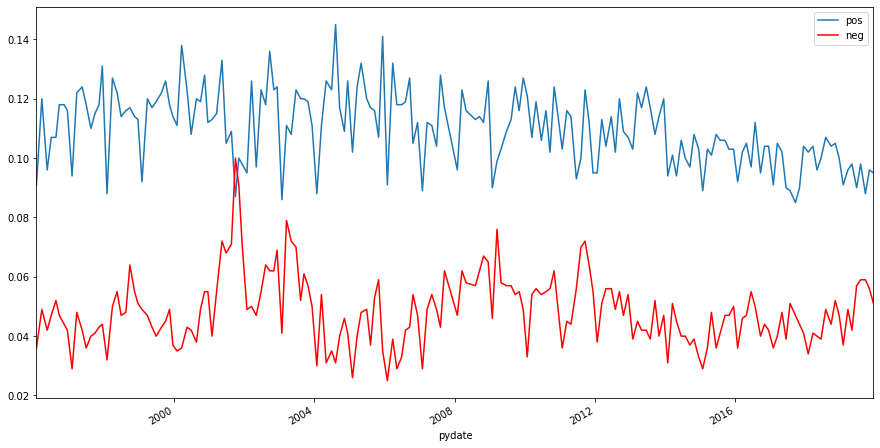

 
Chart 1 - The Length of text in FOMC Minutes (1996-2019)


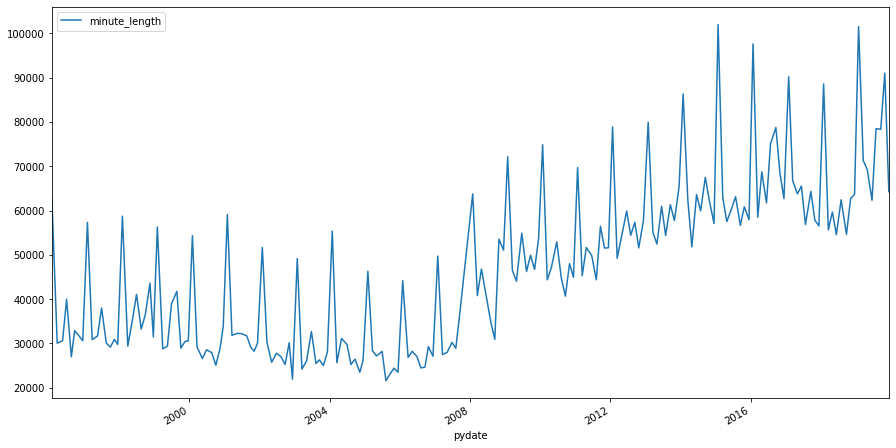

CPU times: user 701 ms, sys: 25 ms, total: 726 ms
Wall time: 776 ms


In [0]:
%%time
dfScores.reset_index(inplace = True, drop=True)

dfEDA = dfScores.merge(df.drop(columns=['text']), left_index=True, right_index=True)

dfTable0 = dfEDA[['year', 'pos', 'neg', 'neu']]
dfChart0 = dfEDA[['pydate', 'pos', 'neg', 'neu']]
dfChart1 = dfEDA[['pydate', 'minute_length']]
print("Table 0 - The Positive, Negative and Neutral Sentiment in FOMC Minutes (1990-2019)")

display(dfTable0.groupby('year').mean())

print(" ")
print("Chart 0 - The Positive and Negative Sentiment in FOMC Minutes (1996-2019)")

plt.figure(figsize=(15,8))
ax = plt.gca()

dfChart0.plot(kind='line',x='pydate',y='pos',ax=ax)
dfChart0.plot(kind='line',x='pydate',y='neg', color='red', ax=ax)

plt.show()

print(" ")
print("Chart 1 - The Length of text in FOMC Minutes (1996-2019)")

plt.figure(figsize=(15,8))
ax = plt.gca()

dfChart1.plot(kind='line',x='pydate',y='minute_length',ax=ax)

plt.show()




**Step 5:** Some Pearson Correlation coeffecients from comparing our sentiment scores to The National Employment Level, Job Openings Rate and Hires Rate for the US as a whole.

In [0]:
def get_bls_data(url, series, val):
    '''
    URL: parameter takes the end part of location of the web table from BLS website
    series: parameter takes the unique series code of a BLS data series
    val: parameter takes the name I want to give to a particular column
    '''
    global dfBLS
    dfBLS = pd.read_csv('https://download.bls.gov/pub/time.series/%s' % (url), sep='\t', header=0)
    dfBLS = dfBLS[dfBLS['series_id        '].str.contains("%s" % (series))]
    dfBLS = dfBLS[~dfBLS.period.str.contains("Q")] # dropping Quarterly data if there is any
    dfBLS['month'] = dfBLS['period'].map(lambda x: x.lstrip('M')).astype(int)
    dfBLS['year'] = dfBLS['year'].astype(int)
    dfBLS['%s'  % (val)] = dfBLS['       value']
    dfBLS = dfBLS[['year','month','%s' % (val)]]

get_bls_data(url = "ce/ce.data.00a.TotalNonfarm.Employment", series = "CES0000000001", val ="emp")
dfCES = dfBLS
get_bls_data(url = "jt/jt.data.2.JobOpenings", series = "JTS00000000JOR", val ="openings" )
dfJO = dfBLS
get_bls_data(url = "jt/jt.data.3.Hires", series = "JTS00000000HIR", val ="hires")
dfHI = dfBLS

data_frame_list = [dfHI, dfJO, dfCES, dfEDA]
dfMerged = reduce(lambda  left,right: pd.merge(left,right,on=['year', 'month'], how='outer'), data_frame_list)

pearsoncorr = dfMerged.corr(method='pearson')
display(pearsoncorr)

,year,month,hires,openings,emp,neg,neu,pos,compound
year,1.000000,-0.050986,-0.208023,0.609325,0.991445,-0.120499,0.389466,-0.444307,0.065995
month,-0.050986,1.000000,0.007589,-0.013491,-0.017708,0.131531,-0.205890,0.172568,0.104377
hires,-0.208023,0.007589,1.000000,0.585823,0.312792,-0.083222,0.047757,0.009338,-0.181292
openings,0.609325,-0.013491,0.585823,1.000000,0.904259,-0.239483,0.437419,-0.420728,-0.037805
emp,0.991445,-0.017708,0.312792,0.904259,1.000000,-0.085275,0.338103,-0.408873,0.048807
neg,-0.120499,0.131531,-0.083222,-0.239483,-0.085275,1.000000,-0.722366,0.077260,-0.316058
neu,0.389466,-0.205890,0.047757,0.437419,0.338103,-0.722366,1.000000,-0.744750,0.116122
pos,-0.444307,0.172568,0.009338,-0.420728,-0.408873,0.077260,-0.744750,1.000000,0.137574
compound,0.065995,0.104377,-0.181292,-0.037805,0.048807,-0.316058,0.116122,0.137574,1.000000
